## Trading Strategy Development and Data Analysis Exercise

### Objective
You are tasked with developing a trading strategy that leverages traditional market data along with economic datasets. We're interested in how commodity price movements, particularly in the oil market, correlate with external economic factors and how we might use this relationship to inform our trading decisions.

### Resources Provided
Data Ingestion: Access to pre-sourced market and economic datasets.

Data Preprocessing and Integration: Datasets are already preprocessed and integrated.

Exploratory Data Analysis (EDA): Initial insights and trends from foundational EDA are provided. You're encouraged to further explore correlations and patterns, e.g. using your understanding of global events to interpret significant price movements.

### Main Task: Strategy Development

- Develop a trading strategy that utilizes insights from both market data and economic indicators.
- Use the backtesting framework from [Backtesting.py Documentation](https://kernc.github.io/backtesting.py/doc/backtesting/) for strategy implementation.

### Strategy Testing
- Test your strategy's effectiveness using the provided backtesting framework, which computes various statistics e.g. cumulative returns and the Sharpe ratio.
- Analyse the risk-adjusted performance and robustness of your strategy.


In [ ]:
# Install required packages using a Virtual Environment

from datetime import datetime

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_palette("deep")
import yfinance as yf

from backtesting import Backtest, Strategy
from backtesting.lib import crossover
from backtesting.test import SMA

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import display, Markdown

### 1. Data Ingestion
For this task, we have provided two key datasets:
- Equity market data for tickers CL=F and BZ=F sourced from `yfinance` for a 2-year period at daily intervals.
- Economic Policy Uncertainty (EPU) Index data from the same period, sourced from https://fred.stlouisfed.org/series/USEPUINDXD.

<div class="alert alert-info">

#### 1.1 Background research

##### 1.1.1 Crude Oil
Crude oil is a raw, unrefined petroleum product extracted from the ground. It is a key commodity and one of the most actively traded commodities in the world.

"CL" is the commodity code or ticker symbol used to represent West Texas Intermediate (WTI) crude oil in financial markets. West Texas Intermediate (WTI) is a grade of crude oil that serves as a major benchmark in oil pricing.

"BZ" is the commodity code or ticker symbol used to represent Brent Crude Oil in financial markets. Brent Crude is a major trading classification of crude oil that serves as a major benchmark price for purchases worldwide.

The "F" at the end of "CL=F" and "BZ=F" signifies that this is a futures contract. Futures contracts are standardized agreements to buy or sell a specific amount of an underlying asset (in this case, crude oil) at a predetermined price on a specified future date.

<br>

West Texas Intermediate (WTI) and Brent Crude are two major classifications of sweet light crude oil. "Sweet" crude oil refers to oil that has a low sulfur content. Low sulfur levels make the oil easier to refine, resulting in fewer impurities and less pollution during the refining process. "Light" crude oil refers to oil that has a low density or low specific gravity. Light crude oils have a higher ratio of hydrocarbons to impurities, making them easier to process in refineries.
* WTI is extracted primarily from wells in the United States, with a significant portion coming from the Permian Basin in West Texas. It's known for its relatively high quality, low sulfur content, and light density.
* Brent Crude is sourced from the North Sea and consists of a blend of several crude oils from different oil fields. Brent Crude is also considered a high-quality crude oil with low sulfur content and a relatively light density.

<br>

##### 1.1.2 Economic Policy Uncertainty (EPU)

The Economic Policy Uncertainty (EPU) is an index that attempts to quantify the degree of uncertainty surrounding economic policy decisions and their potential impact on economic conditions.

The Economic Policy Uncertainty Index is often based on the following components:
* News Coverage: The frequency of news articles and media coverage related to economic policy. An increase in coverage may indicate a higher level of uncertainty.
* Tax Code Provisions: Changes or uncertainty in tax policies, including potential revisions to tax codes and regulations.
* Government Spending: Uncertainty related to government spending and budget decisions, including debates on fiscal policies.
* Trade and Monetary Policy: The uncertainty associated with trade policy like international trade policies, tariffs, and trade agreements; or monetary policy like central bank decisions, interest rate changes, and monetary policy actions.
* Regulatory Environment: Changes or uncertainties in regulations affecting businesses and industries.
* Political Climate: The overall political environment, including elections and political instability.

</div>

In [2]:
# Equity market data for Crude Oil and Brent Crude Oil
tickers = ['CL=F', 'BZ=F']

# Downloading 'Open', 'High', 'Low', and 'Close' for each ticker
market_data = yf.download(tickers, start=datetime(2022, 1, 1), end=datetime(2024, 1, 1))[["Open", "High", "Low", "Close"]]
market_data.head()

[*********************100%%**********************]  2 of 2 completed


Price            Open                  High                   Low             \
Ticker           BZ=F       CL=F       BZ=F       CL=F       BZ=F       CL=F   
Date                                                                           
2022-01-03  77.940002  75.690002  79.279999  76.459999  77.040001  74.269997   
2022-01-04  78.949997  76.019997  80.550003  77.639999  78.599998  75.699997   
2022-01-05  80.080002  77.180000  81.489998  78.580002  79.550003  76.510002   
2022-01-06  80.150002  77.239998  82.839996  80.239998  79.629997  76.730003   
2022-01-07  82.059998  79.620003  82.989998  80.470001  81.440002  78.519997   

Price           Close             
Ticker           BZ=F       CL=F  
Date                              
2022-01-03  78.980003  76.080002  
2022-01-04  80.000000  76.989998  
2022-01-05  80.800003  77.849998  
2022-01-06  81.989998  79.459999  
2022-01-07  81.750000  78.900002

In [3]:
# EPU index data
epu_data = pd.read_csv('datasets/EPU_index.csv', parse_dates=['DATE'], index_col='DATE')
epu_data.head()

,USEPUINDXD
DATE,
2022-01-01,169.59
2022-01-02,157.01
2022-01-03,146.60
2022-01-04,192.08
2022-01-05,111.08



### 2. Data Preprocessing and Integration [Provided]


In [4]:
# Split market data into two separate datasets and join each with EPU index data
crude_epu_data = market_data.xs('CL=F', level=1, axis=1).join(epu_data)
brent_epu_data = market_data.xs('BZ=F', level=1, axis=1).join(epu_data)
crude_epu_data.head()
brent_epu_data.head()

,Open,High,Low,Close,USEPUINDXD
Date,,,,,
2022-01-03,75.690002,76.459999,74.269997,76.080002,146.60
2022-01-04,76.019997,77.639999,75.699997,76.989998,192.08
2022-01-05,77.180000,78.580002,76.510002,77.849998,111.08
2022-01-06,77.239998,80.239998,76.730003,79.459999,235.10
2022-01-07,79.620003,80.470001,78.519997,78.900002,57.41


,Open,High,Low,Close,USEPUINDXD
Date,,,,,
2022-01-03,77.940002,79.279999,77.040001,78.980003,146.60
2022-01-04,78.949997,80.550003,78.599998,80.000000,192.08
2022-01-05,80.080002,81.489998,79.550003,80.800003,111.08
2022-01-06,80.150002,82.839996,79.629997,81.989998,235.10
2022-01-07,82.059998,82.989998,81.440002,81.750000,57.41


### 3. Exploratory Data Analysis
Identify trends or correlations between the equity price movements and the EPU index using visualisations.

#### 3.1 Stock Close Price and EPU Index Value

In [5]:
# Make a DataFrame with useful data for legibility
data = pd.DataFrame({
    'Crude Oil Close': crude_epu_data['Close'],
    'Brent Oil Close': brent_epu_data['Close'],
    'EPU Index': crude_epu_data['USEPUINDXD']
})

data.head()

,Crude Oil Close,Brent Oil Close,EPU Index
Date,,,
2022-01-03,76.080002,78.980003,146.60
2022-01-04,76.989998,80.000000,192.08
2022-01-05,77.849998,80.800003,111.08
2022-01-06,79.459999,81.989998,235.10
2022-01-07,78.900002,81.750000,57.41


##### 3.1.1 Trend

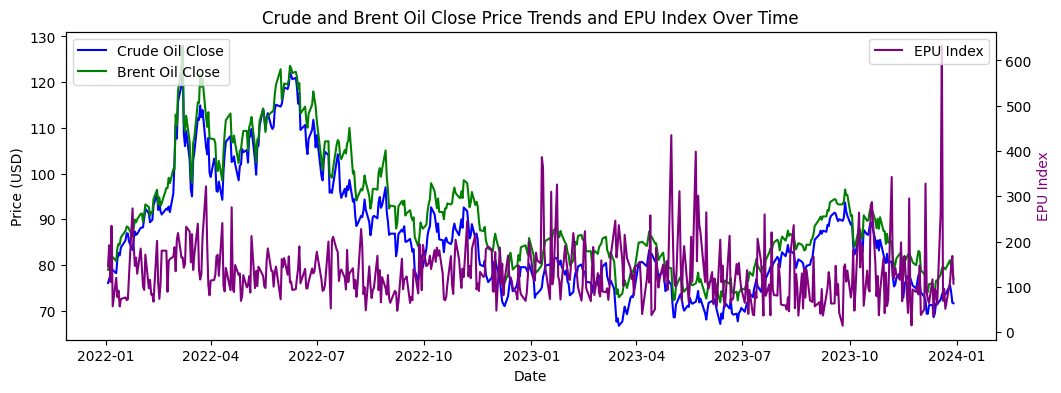

In [6]:
# Plotting
fig, ax1 = plt.subplots(figsize=(12, 4))
ax1.plot(data.index, data['Crude Oil Close'], label='Crude Oil Close', color='blue')
ax1.plot(data.index, data['Brent Oil Close'], label='Brent Oil Close', color='green')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price (USD)')
ax1.legend(loc='upper left')

# Creating a second y-axis for EPU index
ax2 = ax1.twinx()
ax2.plot(data.index, data['EPU Index'], label='EPU Index', color='purple')
ax2.set_ylabel('EPU Index', color='purple')
ax2.legend(loc='upper right')

plt.title('Crude and Brent Oil Close Price Trends and EPU Index Over Time')
plt.show();

#### 3.1.2 Rolling Average (30d and 90d) Trend

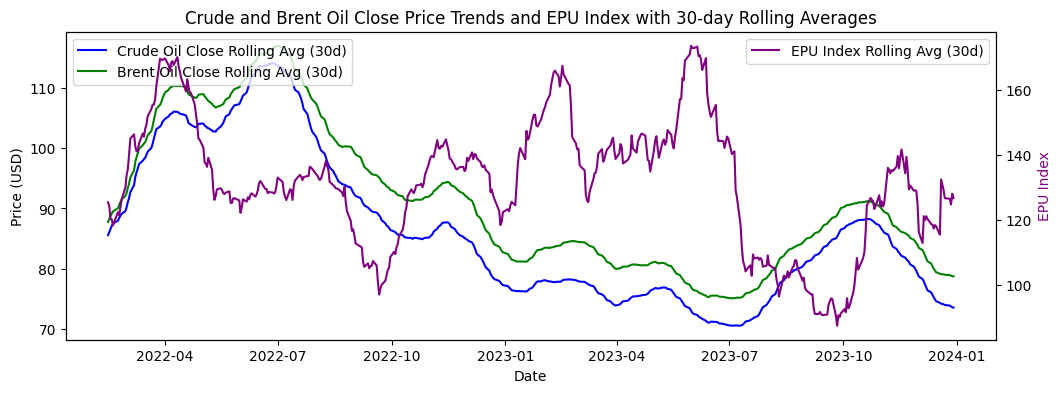

In [7]:
# Calculate 20-day rolling averages
data_r30 = data.rolling(window=30).mean()

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 4))
ax1.plot(data_r30.index, data_r30['Crude Oil Close'], label='Crude Oil Close Rolling Avg (30d)', color='blue')
ax1.plot(brent_epu_data.index, data_r30['Brent Oil Close'], label='Brent Oil Close Rolling Avg (30d)', color='green')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price (USD)')
ax1.legend(loc='upper left')

# Creating a second y-axis for EPU index
ax2 = ax1.twinx()
ax2.plot(data_r30.index, data_r30['EPU Index'], label='EPU Index Rolling Avg (30d)', color='purple')
ax2.set_ylabel('EPU Index', color='purple')
ax2.legend(loc='upper right')

plt.title('Crude and Brent Oil Close Price Trends and EPU Index with 30-day Rolling Averages')
plt.show();

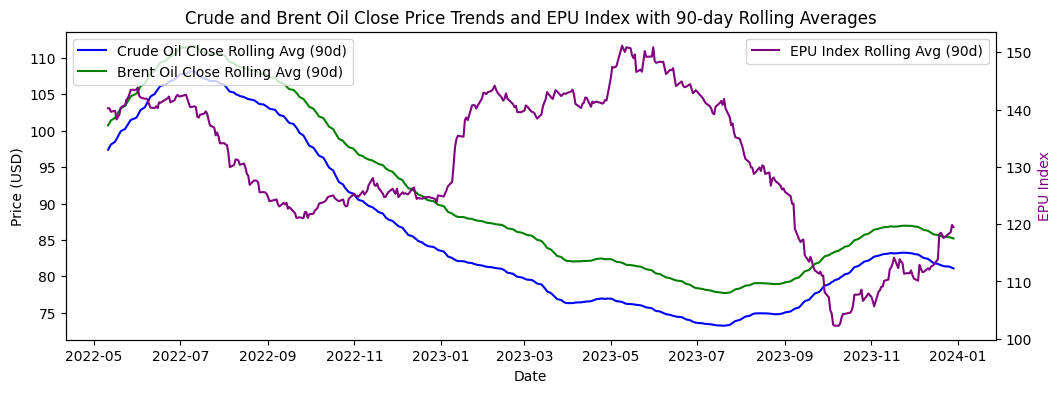

In [8]:
# Calculate 20-day rolling averages
data_r90 = data.rolling(window=90).mean()

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 4))
ax1.plot(data_r90.index, data_r90['Crude Oil Close'], label='Crude Oil Close Rolling Avg (90d)', color='blue')
ax1.plot(brent_epu_data.index, data_r90['Brent Oil Close'], label='Brent Oil Close Rolling Avg (90d)', color='green')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price (USD)')
ax1.legend(loc='upper left')

# Creating a second y-axis for EPU index
ax2 = ax1.twinx()
ax2.plot(data_r90.index, data_r90['EPU Index'], label='EPU Index Rolling Avg (90d)', color='purple')
ax2.set_ylabel('EPU Index', color='purple')
ax2.legend(loc='upper right')

plt.title('Crude and Brent Oil Close Price Trends and EPU Index with 90-day Rolling Averages')
plt.show();

#### 3.1.3 Volatility Analysis

In [9]:
# Calculate additional volatility measures
data_std = data.pct_change().std()
data_mean = data.pct_change().mean()

# Create a DataFrame for volatility measures
volatility_table = pd.DataFrame({
    'Std Deviation': data_std,
    'Mean': data_mean,
})

title = "#### Stock Price and EPU Index Volatility Analysis\nStandard Deviation and Mean of Percentage Daily Returns"
display(Markdown(title))
display(volatility_table)

#### Stock Price and EPU Index Volatility Analysis
Standard Deviation and Mean of Percentage Daily Returns

,Std Deviation,Mean
Crude Oil Close,0.026209,0.000225
Brent Oil Close,0.025205,0.000269
EPU Index,0.971477,0.222722


#### 3.1.4 Correlation Analysis

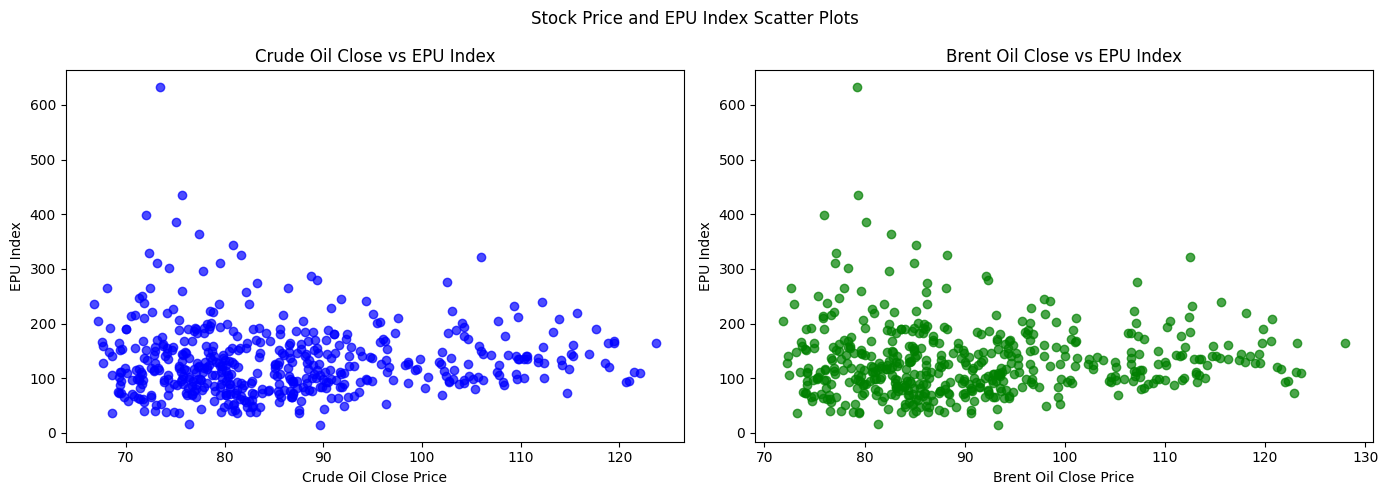

In [10]:
# Plot scatter plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot for CL vs EPU
ax1.scatter(data['Crude Oil Close'], data['EPU Index'], color='blue', alpha=0.7)
ax1.set_xlabel('Crude Oil Close Price')
ax1.set_ylabel('EPU Index')
ax1.set_title(f'Crude Oil Close vs EPU Index')

# Scatter plot for BZ vs EPU
ax2.scatter(data['Brent Oil Close'], data['EPU Index'], color='green', alpha=0.7)
ax2.set_xlabel('Brent Oil Close Price')
ax2.set_ylabel('EPU Index')
ax2.set_title(f'Brent Oil Close vs EPU Index')

plt.suptitle("Stock Price and EPU Index Scatter Plots")
plt.tight_layout()
plt.show();

In [11]:
# Calculate the correlation matrix
correlation_matrix = data.corr()

# Display the correlation matrix as a table
styled_table = correlation_matrix.style.background_gradient(cmap='coolwarm', axis=None).format("{:.2f}")
title = "#### Stock Price and EPU Index Value Correlation Heatmap"
display(Markdown(title))
display(styled_table)

#### Stock Price and EPU Index Value Correlation Heatmap

,Crude Oil Close,Brent Oil Close,EPU Index
Crude Oil Close,1.00,0.99,0.02
Brent Oil Close,0.99,1.00,0.02
EPU Index,0.02,0.02,1.00


<div class="alert alert-warning">

#### Over the past two years, the stock prices of CL=F and BZ=F at close have been highly correlated, with a **99%** value. That is to be expected since they are both oil prices, though different types.

</div>

Crude oil prices and the EPU Index are measured on different scales and units. Comparing their raw values directly isn't meaningful because a specific numerical change in one doesn't have the same significance in the other.

When you look at percentage changes, you're analyzing relative movements rather than absolute levels. This allows you to see if there's a relationship in the way they move—do they tend to go up and down together (positive correlation) or in opposite directions (negative correlation)?

In [12]:
# Calculate the correlation matrix
correlation_matrix = data.pct_change().corr()

# Display the correlation matrix as a table
styled_table = correlation_matrix.style.background_gradient(cmap='coolwarm', axis=None).format("{:.2f}")
title = "#### Stock Price Pct Daily Returns and EPU Index Pct Change Correlation Heatmap"
display(Markdown(title))
display(styled_table)

#### Stock Price Pct Daily Returns and EPU Index Pct Change Correlation Heatmap

,Crude Oil Close,Brent Oil Close,EPU Index
Crude Oil Close,1.00,0.94,-0.02
Brent Oil Close,0.94,1.00,-0.01
EPU Index,-0.02,-0.01,1.00


In [13]:
# Calculating percentage changes
data_lag = data.pct_change()

# Introducing lags for both columns
lags = [5, 30, 90, 180, 270, 360]
for lag in lags:
    for column in data.columns:
        data_lag[f'{column} Lag_{lag}'] = data_lag[column].shift(lag)

# Calculating the correlation matrix including the lags
correlation_matrix = data_lag.corr()

# Display the correlation matrix as a table
styled_table = correlation_matrix.style.background_gradient(cmap='coolwarm', axis=None).format("{:.2f}")
title = "#### (With Lags) Stock Price and EPU Index Correlation Heatmap\nStock Price is intended as daily percentage returns, EPU Index is intended as daily percentage change in EPU Index."
display(Markdown(title))
display(styled_table)

#### (With Lags) Stock Price and EPU Index Correlation Heatmap
Stock Price is intended as daily percentage returns, EPU Index is intended as daily percentage change in EPU Index.

,Crude Oil Close,Brent Oil Close,EPU Index,Crude Oil Close Lag_5,Brent Oil Close Lag_5,EPU Index Lag_5,Crude Oil Close Lag_30,Brent Oil Close Lag_30,EPU Index Lag_30,Crude Oil Close Lag_90,Brent Oil Close Lag_90,EPU Index Lag_90,Crude Oil Close Lag_180,Brent Oil Close Lag_180,EPU Index Lag_180,Crude Oil Close Lag_270,Brent Oil Close Lag_270,EPU Index Lag_270,Crude Oil Close Lag_360,Brent Oil Close Lag_360,EPU Index Lag_360
Crude Oil Close,1.00,0.94,-0.02,-0.07,-0.09,-0.02,-0.04,-0.05,-0.03,-0.02,-0.01,-0.01,-0.02,-0.02,-0.08,-0.03,0.02,-0.04,-0.02,-0.00,-0.02
Brent Oil Close,0.94,1.00,-0.01,-0.09,-0.11,-0.03,-0.02,-0.03,-0.03,-0.01,-0.01,-0.00,-0.01,-0.02,-0.10,-0.02,0.02,-0.00,-0.03,-0.01,-0.04
EPU Index,-0.02,-0.01,1.00,0.04,0.03,0.04,-0.02,-0.02,0.02,0.07,0.06,0.14,-0.01,0.01,-0.04,0.04,0.05,-0.07,0.10,0.02,-0.11
Crude Oil Close Lag_5,-0.07,-0.09,0.04,1.00,0.94,-0.02,0.03,0.01,0.00,0.06,0.00,0.09,0.03,0.04,0.04,-0.04,-0.01,-0.00,-0.00,-0.03,0.00
Brent Oil Close Lag_5,-0.09,-0.11,0.03,0.94,1.00,-0.02,0.00,-0.02,-0.00,0.03,0.01,0.08,0.05,0.05,0.02,-0.05,-0.01,-0.03,-0.02,-0.03,-0.01
EPU Index Lag_5,-0.02,-0.03,0.04,-0.02,-0.02,1.00,0.00,0.00,0.00,0.02,0.03,0.03,0.03,0.04,-0.06,0.04,-0.00,-0.08,-0.01,0.01,0.00
Crude Oil Close Lag_30,-0.04,-0.02,-0.02,0.03,0.00,0.00,1.00,0.94,-0.03,-0.06,-0.06,0.07,0.08,0.06,-0.03,-0.03,-0.02,0.14,-0.10,-0.06,-0.09
Brent Oil Close Lag_30,-0.05,-0.03,-0.02,0.01,-0.02,0.00,0.94,1.00,-0.02,-0.07,-0.08,0.05,0.07,0.05,-0.01,-0.02,-0.01,0.14,-0.10,-0.06,-0.05
EPU Index Lag_30,-0.03,-0.03,0.02,0.00,-0.00,0.00,-0.03,-0.02,1.00,0.04,0.03,-0.02,-0.03,-0.03,0.00,-0.06,-0.06,-0.04,-0.03,0.01,0.03
Crude Oil Close Lag_90,-0.02,-0.01,0.07,0.06,0.03,0.02,-0.06,-0.07,0.04,1.00,0.93,-0.05,-0.03,-0.01,0.01,-0.05,-0.05,-0.04,-0.03,0.01,-0.16


<div class="alert alert-warning">

#### There seems to be **no significant correlation** between the daily percentage returns of oil prices and daily percentage change of EPU Index, even including lags.
</div>

### 3.2 Stock Close Price and EPU Index Volatility

In [14]:
# Calculate the correlation matrix
data_vol = data.copy()
data_vol['EPU Index'] = data['EPU Index'].pct_change().rolling(window=30).std()
correlation_matrix = data_vol.corr()

# Display the correlation matrix as a table
styled_table = correlation_matrix.style.background_gradient(cmap='coolwarm', axis=None).format("{:.2f}")
title = "#### Stock Price Volatility and EPU Index Volatility Correlation Heatmap\nVolatility intended as 30-day StD."
display(Markdown(title))
display(styled_table)

#### Stock Price Volatility and EPU Index Volatility Correlation Heatmap
Volatility intended as 30-day StD.

,Crude Oil Close,Brent Oil Close,EPU Index
Crude Oil Close,1.00,0.99,-0.43
Brent Oil Close,0.99,1.00,-0.47
EPU Index,-0.43,-0.47,1.00


In [15]:
# Calculate the correlation matrix
data_vol = data.copy()
data_vol['EPU Index'] = data['EPU Index'].pct_change().rolling(window=30).std()

# Introducing lags for both columns
for lag in lags:
    for column in data.columns:
        data_vol[f'{column[:5]} Lag_{lag}'] = data_vol[column].shift(lag)

# Calculating the correlation matrix including the lags
correlation_matrix = data_vol.corr()

# Display the correlation matrix as a table
styled_table = correlation_matrix.style.background_gradient(cmap='coolwarm', axis=None).format("{:.2f}")
title = "#### (With Lags) Stock Price and EPU Index Volatility Correlation Heatmap\nVolatility intended as 30-day StD."
display(Markdown(title))
display(styled_table)

#### (With Lags) Stock Price and EPU Index Volatility Correlation Heatmap
Volatility intended as 30-day StD.

,Crude Oil Close,Brent Oil Close,EPU Index,Crude Lag_5,Brent Lag_5,EPU I Lag_5,Crude Lag_30,Brent Lag_30,EPU I Lag_30,Crude Lag_90,Brent Lag_90,EPU I Lag_90,Crude Lag_180,Brent Lag_180,EPU I Lag_180,Crude Lag_270,Brent Lag_270,EPU I Lag_270,Crude Lag_360,Brent Lag_360,EPU I Lag_360
Crude Oil Close,1.00,0.99,-0.43,0.91,0.90,-0.42,0.69,0.65,-0.32,0.27,0.21,-0.27,-0.19,-0.24,0.37,-0.30,-0.24,0.44,0.42,0.43,0.12
Brent Oil Close,0.99,1.00,-0.47,0.91,0.91,-0.46,0.72,0.68,-0.36,0.36,0.30,-0.31,-0.09,-0.15,0.30,-0.37,-0.32,0.44,0.44,0.45,0.12
EPU Index,-0.43,-0.47,1.00,-0.44,-0.48,0.93,-0.42,-0.46,0.69,-0.63,-0.64,0.73,-0.65,-0.61,0.28,-0.38,-0.28,-0.17,0.37,0.40,0.44
Crude Lag_5,0.91,0.91,-0.44,1.00,0.99,-0.42,0.72,0.69,-0.33,0.31,0.24,-0.23,-0.15,-0.19,0.42,-0.42,-0.36,0.42,0.52,0.52,0.09
Brent Lag_5,0.90,0.91,-0.48,0.99,1.00,-0.47,0.74,0.71,-0.36,0.40,0.33,-0.29,-0.03,-0.09,0.34,-0.47,-0.43,0.41,0.53,0.53,0.05
EPU I Lag_5,-0.42,-0.46,0.93,-0.42,-0.47,1.00,-0.42,-0.46,0.71,-0.62,-0.64,0.70,-0.65,-0.62,0.34,-0.43,-0.35,-0.03,0.48,0.50,0.34
Crude Lag_30,0.69,0.72,-0.42,0.72,0.74,-0.42,1.00,0.99,-0.37,0.53,0.48,-0.13,-0.09,-0.14,0.23,-0.55,-0.51,0.29,0.62,0.62,-0.32
Brent Lag_30,0.65,0.68,-0.46,0.69,0.71,-0.46,0.99,1.00,-0.42,0.59,0.54,-0.19,0.03,-0.02,0.13,-0.54,-0.51,0.27,0.62,0.61,-0.32
EPU I Lag_30,-0.32,-0.36,0.69,-0.33,-0.36,0.71,-0.37,-0.42,1.00,-0.53,-0.55,0.70,-0.65,-0.65,0.25,-0.35,-0.28,0.13,0.37,0.38,-0.63
Crude Lag_90,0.27,0.36,-0.63,0.31,0.40,-0.62,0.53,0.59,-0.53,1.00,0.99,-0.48,0.30,0.23,-0.44,-0.09,-0.18,-0.05,-0.18,-0.13,-0.23


<div class="alert alert-warning">

#### There seems to be a **moderate to strong inverse correlation** between Crude Oil prices and EPU Index Volatility (30d StD), peaking at around **60%** at 90-180 days of lag.

</div>

### 3.3 Stock Close Price Volatility and EPU Index Volatility

In [16]:
# Calculate the correlation matrix
correlation_matrix = data.pct_change().rolling(window=90).std().corr()

# Display the correlation matrix as a table
styled_table = correlation_matrix.style.background_gradient(cmap='coolwarm', axis=None).format("{:.2f}")
title = "#### Stock Price Pct Daily Returns Volatility and EPU Index Volatility Correlation Heatmap\nVolatility intended as 90-day StD."
display(Markdown(title))
display(styled_table)

#### Stock Price Pct Daily Returns Volatility and EPU Index Volatility Correlation Heatmap
Volatility intended as 90-day StD.

,Crude Oil Close,Brent Oil Close,EPU Index
Crude Oil Close,1.00,0.99,-0.73
Brent Oil Close,0.99,1.00,-0.70
EPU Index,-0.73,-0.70,1.00


In [17]:
# Calculate the correlation matrix
data_vol2 = data.pct_change().rolling(window=90).std()

# Introducing lags for both columns
for lag in lags:
    for column in data.columns:
        data_vol2[f'{column[:5]} Lag_{lag}'] = data_vol2[column].shift(lag)

# Calculating the correlation matrix including the lags
correlation_matrix = data_vol2.corr()

# Display the correlation matrix as a table
styled_table = correlation_matrix.style.background_gradient(cmap='coolwarm', axis=None).format("{:.2f}")
title = "#### (With Lags) Stock Price Pct Daily Returns Volatility and EPU Index Volatility Correlation Heatmap\nVolatility intended as 90-day StD."
display(Markdown(title))
display(styled_table)

#### (With Lags) Stock Price Pct Daily Returns Volatility and EPU Index Volatility Correlation Heatmap
Volatility intended as 90-day StD.

,Crude Oil Close,Brent Oil Close,EPU Index,Crude Lag_5,Brent Lag_5,EPU I Lag_5,Crude Lag_30,Brent Lag_30,EPU I Lag_30,Crude Lag_90,Brent Lag_90,EPU I Lag_90,Crude Lag_180,Brent Lag_180,EPU I Lag_180,Crude Lag_270,Brent Lag_270,EPU I Lag_270,Crude Lag_360,Brent Lag_360,EPU I Lag_360
Crude Oil Close,1.00,0.99,-0.73,0.99,0.99,-0.73,0.91,0.93,-0.69,0.86,0.88,-0.63,0.62,0.64,-0.43,0.75,0.73,-0.69,-0.10,-0.34,-0.17
Brent Oil Close,0.99,1.00,-0.70,0.98,0.99,-0.69,0.89,0.92,-0.65,0.87,0.88,-0.57,0.60,0.64,-0.34,0.55,0.51,-0.61,-0.10,-0.34,-0.17
EPU Index,-0.73,-0.70,1.00,-0.74,-0.71,0.99,-0.76,-0.75,0.96,-0.78,-0.76,0.88,-0.92,-0.91,0.81,-0.83,-0.87,0.45,0.02,-0.21,-0.15
Crude Lag_5,0.99,0.98,-0.74,1.00,0.99,-0.74,0.93,0.94,-0.70,0.87,0.90,-0.65,0.66,0.67,-0.53,0.81,0.79,-0.72,-0.15,-0.43,-0.09
Brent Lag_5,0.99,0.99,-0.71,0.99,1.00,-0.70,0.91,0.93,-0.67,0.88,0.90,-0.61,0.65,0.67,-0.45,0.64,0.61,-0.67,-0.17,-0.43,-0.09
EPU I Lag_5,-0.73,-0.69,0.99,-0.74,-0.70,1.00,-0.76,-0.74,0.96,-0.76,-0.74,0.89,-0.92,-0.90,0.82,-0.85,-0.88,0.50,-0.20,-0.42,-0.14
Crude Lag_30,0.91,0.89,-0.76,0.93,0.91,-0.76,1.00,0.99,-0.75,0.86,0.89,-0.73,0.82,0.79,-0.81,0.74,0.74,-0.54,-0.19,-0.35,0.15
Brent Lag_30,0.93,0.92,-0.75,0.94,0.93,-0.74,0.99,1.00,-0.73,0.89,0.91,-0.73,0.81,0.79,-0.80,0.75,0.74,-0.58,-0.21,-0.43,0.07
EPU I Lag_30,-0.69,-0.65,0.96,-0.70,-0.67,0.96,-0.75,-0.73,1.00,-0.70,-0.69,0.92,-0.89,-0.87,0.82,-0.90,-0.92,0.58,-0.04,-0.11,-0.21
Crude Lag_90,0.86,0.87,-0.78,0.87,0.88,-0.76,0.86,0.89,-0.70,1.00,0.99,-0.67,0.83,0.87,-0.63,0.06,0.05,0.33,0.30,0.58,-0.07


<div class="alert alert-warning">

#### There seems to be a **very strong inverse correlation** between EPU Index Volatility and Crude Oil Prices' Volatility (90d StD), peaking at about **90%** at 180 days of lag.
</div>

<div class="alert alert-info">

### Relevant Findings

Over the past two years: 
* CL=F and BZ=F close prices have had **low volatility**, while EPU index has had **very high volatility**.

| | Average change in percentage daily returns (2-year mean) | Percentage volatility of percentage daily returns (2-year StD) |
|----------|----------|----------|
| CL=F Close | **0.02%** | **2.6%** |
| BZ=F Close | **0.03%** | **2.5%** |
| EPU Index | **22%** | **97%** |
    
* The stock prices of CL=F and BZ=F at close have been **highly correlated**, with a **99%** value.
* There seems to be **no significant correlation** between the daily percentage returns of oil prices and daily percentage change of EPU Index, even including lags.
* There seems to be a **moderate to strong inverse correlation** between Crude Oil prices and EPU Index Volatility (30d StD), peaking at around **60% at 90-180 days** of lag.
* There seems to be a **very strong inverse correlation** between EPU Index Volatility (90d StD) and Crude Oil Prices' Volatility (90d StD), peaking at around **90% at 180 days** of lag.

</div>

<div class="alert alert-info">

### Discussion

It is expected that the stock prices of CL=F and BZ=F would be highly correlated, since they are both oil prices, though they are different types of crude oil.

It is more challenging to identify a relationship between the EPU Index and crude oil prices. This part of the analysis has showed that overall, _the change in value of the EPU Index is not enough to predict the change in crude oil prices at any point in time_, i.e. they do not have a significant correlation. 
* This is likely because of the very high volatility of the EPU Index, which is not commonly observed in commodity prices such as crude oil.

However, the degree of volatility in the medium-long term (30-90d) of the EPU Index does have a significant impact on both the price and specifically volatility of crude oil, which is mostly observed after a lag period of around **180 days**. 
* Specifically, there is a **~50%** inverse correlation between EPU Index Volatility (30d StD) and Crude Oil Prices at ~180d lag.
    * If EPU Index has higher volatility, there is a **high chance** the crude oil prices will be lower, and vice versa.
* Additionally, there is a **~90%** inverse correlation between EPU Index Volatility (90d StD) and Crude Oil Prices Volatility (90d StD) at ~180d lag.
    * If EPU Index has higher volatility, there is a **very high chance** the crude oil prices will have less volatility, and vice versa.

</div>

<div class="alert alert-info">

### Conclusion

A profitable trading strategy that utilizes insights from both market data and economic indicators will have these characteristics:
* When EPU Index is in a state of higher volatility, the value of crude oil will be proportionally lower in about 180d. 
    * When EPU volatility is higher, sell crude oil and buy in 180 days.
* When EPU Index is in a state of lower volatility, the value of crude oil will be proportionally higher in about 180d. 
    * When EPU volatility is lower, buy crude oil and sell in 180 days.

Overall, this trading strategy leverages insights from both market data (crude oil prices) and economic indicators (EPU index volatility) to make informed decisions about buying or selling crude oil assets. It aims to capitalize on the expected relationship between EPU volatility and future crude oil prices, providing opportunities for profitable trading within a specified time frame.

</div>

### 4. Strategy Development [Main Task]
Develop a strategy that leverages correlations between equity price movements and external economic factors by editing `NewStrategy`. For documentation on the backtesting library, see: [Backtesting.py Documentation](https://kernc.github.io/backtesting.py/doc/backtesting/).

In [18]:
class SMACrossover(Strategy):
    """
    Simple moving average crossover strategy.
    """
    short_window = 40
    long_window = 100

    def init(self):
        """
        Initialise the strategy by declaring indicators for short and long simple moving averages.
        """
        self.sma_short = self.I(SMA, self.data.Close, self.short_window)
        self.sma_long = self.I(SMA, self.data.Close, self.long_window)

    def next(self):
        """
        Main strategy runtime method. If the short SMA crosses above the long SMA, buy.
        If the short SMA crosses below the long SMA, sell.
        """
        if crossover(self.sma_short, self.sma_long):
            self.buy()

        elif crossover(self.sma_long, self.sma_short):
            self.sell()

In [19]:
def rolling_std(series, window):
    """
    Calculate the rolling standard deviation of an array of percentage changes.
    """
    # Simple implementation of rolling standard deviation
    return pd.Series(series).rolling(window).std()

class VolatilityCrossover(Strategy):
    """
    This strategy leverages the volatility of the Economic Policy Uncertainty (EPU) Index
    to make trading decisions on crude oil futures. It is based on the premise that 
    increases in the volatility of the EPU Index signal potential decreases in oil prices,
    and vice versa. 
    """
    short_window = 40
    long_window = 100

    def init(self):
        """
        Initialise the strategy by declaring indicators for short and long rolling windows.
        """
        # Compute volatility of EPU Index as standard deviation with different rolling windows
        self.short_vol = self.I(rolling_std, self.data.USEPUINDXD, self.short_window)
        self.long_vol = self.I(rolling_std, self.data.USEPUINDXD, self.long_window)

    def next(self):
        """
        Main strategy runtime method. 
        """
        # If short-term volatility crosses above long-term volatility
        # EPU Index volatility is increasing
        # Price of crude oil is expected to decrease
        # Therefore close any long positions and open a short position
        if crossover(self.short_vol, self.long_vol):
            self.position.close()
            self.sell()

        # If long-term volatility crosses above short-term volatility
        # EPU Index volatility is decreasing
        # Price of crude oil is expected to increase
        # Therefore close any short positions and open a long position
        if crossover(self.long_vol, self.short_vol):
            self.position.close()
            self.buy()

### 5. Strategy Testing [Structured]
Evaluate the effectiveness and risk-adjusted performance of your strategy. For this purpose, we have provided the `StrategyExecutor` class and a backtesting example to facilitate the process.

In [20]:
class StrategyExecutor:
    def __init__(self, crude_epu_data, brent_epu_data, cash=10_000, commission=0.002):
        """
        Initialise the executor with the combined data for a specific ticker.
        
        :param crude_epu_data: DataFrame containing the combined data for crude oil and EPU index.
        :param brent_epu_data: DataFrame containing the combined data for brent oil and EPU index.
        :param cash: Starting cash for the backtesting (default 10,000).
        :param commission: Commission per transaction (default 0.002).
        """
        self.crude_epu_data = crude_epu_data
        self.brent_epu_data = brent_epu_data
        self.config = {
            'cash': cash,
            'commission': commission
        }

    def run_strategy_for_ticker(self, strategy, data_type, params=None, display_stats=None):
        """
        Runs the given strategy on the prepared data.

        :param strategy: The strategy class to be executed.
        :param data_type: The type of data to run the strategy on ('crude' or 'brent').
        :param params: Additional parameters for the strategy.
        :param display_stats: List of statistics to display. If None, all stats are returned.
        :return: The backtesting statistics.
        """
        if data_type == 'CL=F':
            data = self.crude_epu_data
        elif data_type == 'BZ=F':
            data = self.brent_epu_data
        else:
            raise ValueError("Invalid data type specified")
        
        # Create a Backtest instance with the filtered data and strategy
        bt = Backtest(data=data,
                      strategy=strategy,
                      cash=self.config['cash'],
                      commission=self.config['commission'],
                      exclusive_orders=True)

        # Run the backtest
        stats = bt.run(**(params or {}))

        # Return the required statistics
        return {stat: stats[stat] for stat in display_stats} if display_stats is not None else stats

In [21]:
# Instantiate the executor then specify the strategy and desired statistics
executor = StrategyExecutor(crude_epu_data, brent_epu_data)
strategy = SMACrossover
desired_stats = ['Return [%]', 'Buy & Hold Return [%]', 'Sharpe Ratio']

for ticker in tickers:
    # Run the strategy for each ticker and specify the parameters
    stats = executor.run_strategy_for_ticker(
        strategy,
        ticker,
        {
            'short_window': 40,
            'long_window': 100
        }, 
        display_stats=desired_stats
    )

    # Print the selected metrics for each ticker
    print(f"Statistics for {strategy.__name__} on {ticker}:")
    for stat, value in stats.items():
        print(f"{stat}: {value}")
    print()

Statistics for SMACrossover on CL=F:
Return [%]: 9.395733583984384
Buy & Hold Return [%]: -5.822818347209244
Sharpe Ratio: 0.17667757557696726

Statistics for SMACrossover on BZ=F:
Return [%]: 10.182767126922608
Buy & Hold Return [%]: -2.4563210419716177
Sharpe Ratio: 0.19546314403752402



In [22]:
# Instantiate the executor then specify the strategy and desired statistics
executor = StrategyExecutor(crude_epu_data, brent_epu_data)
strategy = VolatilityCrossover
desired_stats = ['Return [%]', 'Sharpe Ratio', 'Sortino Ratio', '# Trades', 
                 'Win Rate [%]', 'Best Trade [%]', 'Worst Trade [%]', 'Avg. Trade [%]']

for ticker in tickers:
    # Run the strategy for each ticker and specify the parameters
    stats = executor.run_strategy_for_ticker(
        strategy,
        ticker,
        {
            'short_window': 40,
            'long_window': 100
        }, 
        display_stats=desired_stats
    )

    # Print the selected metrics for each ticker
    print(f"Statistics for {strategy.__name__} on {ticker}:")
    for stat, value in stats.items():
        print(f"{stat}: {value}")
    print()

Statistics for VolatilityCrossover on CL=F:
Return [%]: 53.21421398818966
Sharpe Ratio: 0.6613061839990659
Sortino Ratio: 1.2866037609708525
# Trades: 25
Win Rate [%]: 52.0
Best Trade [%]: 20.09939369526822
Worst Trade [%]: -13.033443636106657
Avg. Trade [%]: 1.7300774940580466

Statistics for VolatilityCrossover on BZ=F:
Return [%]: 36.66112078903196
Sharpe Ratio: 0.5376687603467989
Sortino Ratio: 0.9834969678648605
# Trades: 25
Win Rate [%]: 52.0
Best Trade [%]: 16.451104210304745
Worst Trade [%]: -9.539829781118758
Avg. Trade [%]: 1.2619325313579122

